In [1]:
# do all the needed imports
import pandas as pd
import json
import random
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.spatial as sp
import tensorflow_hub as hub
import tensorflow as tf
import abc
from typing import List
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import csv

In [2]:
%pip install small-text[transformers]==1.0.0b4  # use "small-text" without "[transformers]" if you want to work on the CPU only

# additional dependencies for this example
%pip install datasets matplotlib seaborn

     |████████████████████████████████| 134 kB 9.7 MB/s 
     |████████████████████████████████| 4.2 MB 68.9 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 69.7 MB/s 
     |████████████████████████████████| 6.6 MB 56.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 346 kB 8.7 MB/s 
     |████████████████████████████████| 140 kB 72.4 MB/s 
     |████████████████████████████████| 212 kB 48.6 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 
     |████████████████████████████████| 127 kB 29.9 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 271 kB 78.8 MB/s 
     |████████████████████████████████| 144 kB 67.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib

In [2]:
#get file paths
tweet_file='/content/cleaned_tweets - cleaned_tweets.csv'
tweetClass_file='/content/with_class_cleaned_tweets - with_class_cleaned_tweets.csv'

In [3]:
tweets = pd.read_csv(tweet_file)
tweetsClass=pd.read_csv(tweetClass_file)

To be uncommented when we need to extract unannotated data after everything is done and more labelled data is needed

In [43]:
#remove extra columns
#tweetsClass.drop(tweetsClass.iloc[:, 5:], inplace = True, axis = 1)
#tweetsClass.drop_duplicates(subset="cleanTweets", inplace=True)
#tweets.drop(tweets.iloc[:, 5:], inplace=True, axis=1)
#tweets.drop_duplicates(subset="cleanTweets", inplace=True)

#NotAnnotated = tweetsClass[tweetsClass['Annotation'].isna()]
#NotAnnotated1 = tweets[tweets['Annotation'].isna()]

#filename='/content/NOT_Annotated_tweets.csv'
#NotAnnotated1.to_csv(filename, index = False, encoding='utf-8')

#filename='/content/NOT_Annotated_class_tweets.csv'
#NotAnnotated.to_csv(filename, index = False, encoding='utf-8')

In [4]:
#remove extra columns
tweetsClass.drop(tweetsClass.iloc[:, 5:], inplace = True, axis = 1)
tweetsClass.drop(['tweetsORG','Hashtags'], inplace=True, axis=1)
#remove unannotated rows
tweetsClass.dropna(subset = ['Annotation'], inplace=True)

In [5]:
#remove extra columns
tweets.drop(tweets.iloc[:, 5:], inplace=True, axis=1)
tweets.drop(['tweetsORG','tweetID', 'Hashtags' ], inplace=True, axis=1 )
#add class column
Nan=np.nan
tweets.insert(1, 'Class', value=Nan)
#remove unannotated rows
tweets.dropna(subset = ['Annotation'], inplace=True)

In [8]:
#final data with annotations
data = pd.concat([tweets, tweetsClass], axis=0) 
data.drop_duplicates(subset="cleanTweets", inplace=True)
data.dropna(subset = ['cleanTweets'], inplace=True)

In [25]:
#new annotations
new_annotations= pd.read_csv('/content/NOT_Annotaed.csv')
#remove extra columns
new_annotations.drop(new_annotations.iloc[:, 5:], inplace = True, axis = 1)
new_annotations.drop(['tweetsORG','Hashtags'], inplace=True, axis=1)
#remove unannotated rows
new_annotations.dropna(subset = ['Annotation'], inplace=True)

In [59]:
#new annotations
#new_annotations= pd.read_csv('/content/NOT_Annotaed.csv')

#remove extra columns
#new_annotations.drop(new_annotations.iloc[:, 5:], inplace = True, axis = 1)
#new_annotations.drop_duplicates(subset="cleanTweets", inplace=True)

#NotAnnotated = new_annotations[new_annotations['Annotation'].isna()]

#filename='/content/2ndTest.csv'
#NotAnnotated.to_csv(filename, index = False, encoding='utf-8')

In [28]:
#change string labels to one hot encodig
# relevant = 1 irrelevant = 0
new_annotations['Annotation'].mask(new_annotations['Annotation'] == 'irrelevant', 0, inplace=True)
new_annotations['Annotation'].mask(new_annotations['Annotation'] == 'relevant', 1, inplace=True)
new_annotations['Annotation'].mask(new_annotations['Annotation'] == 'Relevant', 1, inplace=True)
new_annotations['Annotation'].mask(new_annotations['Annotation'] == 'Irrelevant', 0, inplace=True)

In [34]:
#extracting only relevant tweets
rel=new_annotations.loc[new_annotations['Annotation']==1]
rel_count=len(rel)

#extracting relevant tweets same as the size of rel
temp=new_annotations.loc[new_annotations['Annotation']==0]
temp=temp.iloc[:104]

In [36]:
#adding to training set
data = pd.concat([data, rel, temp], axis=0)
data.drop_duplicates(subset="cleanTweets", inplace=True)
data.dropna(subset = ['cleanTweets'], inplace=True)

In [38]:
#change string labels to one hot encodig
# relevant = 1 irrelevant = 0
data['Annotation'].mask(data['Annotation'] == 'irrelevant', 0, inplace=True)
data['Annotation'].mask(data['Annotation'] == 'relevant', 1, inplace=True)
data['Annotation'].mask(data['Annotation'] == 'Irrelevant', 0, inplace=True)

In [46]:
filename='/content/Annotated_tweets_0&1.csv'
data.to_csv(filename, index = False, encoding='utf-8')

Using small text & hugging face 

In [43]:
import datasets
datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

In [44]:
from matplotlib import rcParams
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

In [45]:
import torch
import numpy as np

seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

In [47]:
import logging

raw_dataset = datasets.load_dataset('csv', data_files='/content/Annotated_tweets_0&1.csv')


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c999e5d05a3b5458/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['cleanTweets', 'Class', 'Annotation'],
        num_rows: 1491
    })
})

In [49]:
num_classes = np.unique(raw_dataset['train']['Annotation']).shape[0]

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['Annotation'][i], ' ', raw_dataset['train']['cleanTweets'][i])

First 10 training samples:

0   : It is always nice when the CT and OGD correlate.
0   mohali: Mohali blast: Babbar Khalsa, gangsters backed by ISI carried out the assault: DGP | India News All Places Map
0   Polycystic Kidney Disease Symptoms..
0   "Since Rand Paul (R-Moscow) just unilaterally prevented a critical aid package for Ukraine from passing, a reminder that the last actual Republican, John McCain, said The senator from Kentucky is now working for Vladimir Putin.
1   : Gareth, aged , is the first Australian to require open heart surgery following a severe reaction to the vaccine. He h
0   : Despite Ethiopias declared humanitarian cease-fire with the Tigrayan army, 'aid groups said they are struggling to get food
0   : Since Rand Paul (R-Moscow) just unilaterally prevented a critical aid package for Ukraine from passing, a reminder that
0   : Remember, its only money. It comes and it goes. Your health, family, and friends are far more important $LUNA
0   Good for ur health
0  

In [50]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [51]:
from small_text.integrations.transformers.datasets import TransformersDataset


def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length=max_length,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))

    return TransformersDataset(data_out)


train = get_transformers_dataset(tokenizer, raw_dataset['train']['cleanTweets'], raw_dataset['train']['Annotation'])
#test = get_transformers_dataset(tokenizer, raw_dataset['test']['text'], raw_dataset['test']['label'])

In [61]:
from small_text.active_learner import PoolBasedActiveLearner

from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import PredictionEntropy
from small_text.integrations.transformers import TransformerModelArguments


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=1250)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial



transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

In [62]:
print(len(indices_labeled))

1250


In [63]:
from sklearn.metrics import accuracy_score


num_queries = 11


def evaluate(active_learner, train):
    y_pred = active_learner.classifier.predict(train)
    #y_pred_test = active_learner.classifier.predict(test)
    
    #test_acc = accuracy_score(y_pred_test, test.y)
    train_acc = accuracy_score(y_pred, train.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    #print('Test accuracy: {:.2f}'.format(test_acc))
    
    return train_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled]))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled]))

Train accuracy: 0.93
---------------
Iteration #0 (1270 samples)
Train accuracy: 0.88
---------------
Iteration #1 (1290 samples)
Train accuracy: 0.90
---------------
Iteration #2 (1310 samples)
Train accuracy: 0.89
---------------
Iteration #3 (1330 samples)
Train accuracy: 0.96
---------------
Iteration #4 (1350 samples)
Train accuracy: 0.89
---------------
Iteration #5 (1370 samples)
Train accuracy: 0.94
---------------
Iteration #6 (1390 samples)
Train accuracy: 0.91
---------------
Iteration #7 (1410 samples)
Train accuracy: 0.90
---------------
Iteration #8 (1430 samples)
Train accuracy: 0.88
---------------
Iteration #9 (1450 samples)
Train accuracy: 0.86
---------------
Iteration #10 (1470 samples)
Train accuracy: 0.90


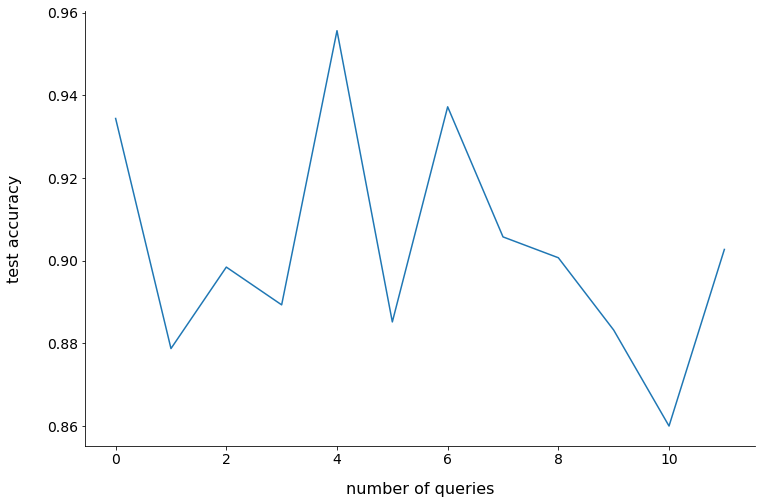

In [64]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)

plt.xlabel('number of queries', labelpad=15)
plt.ylabel('test accuracy', labelpad=25)

sns.despine()

In [74]:
tweets_test = pd.read_csv('/content/NOT_Annotated_tweets.csv')
tweetsClass_test = pd.read_csv('/content/2ndTest.csv')

In [77]:
#remove extra columns
tweetsClass_test.drop(tweetsClass_test.iloc[:, 5:], inplace = True, axis = 1)
tweetsClass_test.drop(['tweetsORG','Hashtags'], inplace=True, axis=1)

#remove extra columns
tweets_test.drop(tweets_test.iloc[:, 5:], inplace=True, axis=1)
tweets_test.drop(['tweetsORG','tweetID', 'Hashtags' ], inplace=True, axis=1 )
#add class column
Nan=np.nan
tweets_test.insert(1, 'Class', value=Nan)

In [81]:
#final data with annotations
data_test = pd.concat([tweets_test, tweetsClass_test], axis=0) 
data_test.drop_duplicates(subset="cleanTweets", inplace=True)

In [82]:
data_pred = data_test[data_test['Annotation'].isna()]

In [85]:
data_pred.drop(['Class'],inplace=True,axis=1)
data_pred.dropna(subset = ['cleanTweets'], inplace=True)
data_pred = data_pred.assign(Annotation=0)

In [88]:
filename='/content/UnAnnotated_tweets_0&1.csv'
data_pred.to_csv(filename, index = False, encoding='utf-8')

In [89]:
raw_data_pred = datasets.load_dataset('csv', data_files={'test':'/content/UnAnnotated_tweets_0&1.csv'})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a2e4f99eef327296/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [90]:
raw_data_pred

DatasetDict({
    test: Dataset({
        features: ['cleanTweets', 'Annotation'],
        num_rows: 62273
    })
})

In [91]:
def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        try:
          encoded_dict = tokenizer.encode_plus(
              doc,
              add_special_tokens=True,
              padding='max_length',
              max_length=max_length,
              return_attention_mask=True,
              return_tensors='pt',
              truncation='longest_first'
          )
        except:
          continue

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))
        

    return TransformersDataset(data_out)


#train = get_transformers_dataset(tokenizer, raw_dataset['train']['cleanTweets'], raw_dataset['train']['Annotation'])
test = get_transformers_dataset(tokenizer, raw_data_pred['test']['cleanTweets'], raw_data_pred['test']['Annotation'])

In [92]:
y_pred_test = active_learner.classifier.predict(test)
print(len(y_pred_test))

62273


In [93]:
data_pred = data_pred.assign(Annotation=y_pred_test)

In [95]:
data_pred

,cleanTweets,Annotation
0,": A year ago today, I woke up with an Always p...",1
1,": Tragically, we are sleepwalking into the nex...",1
2,"Jake Marisnick (UCL, left thumb) placed on -da...",1
3,If I have to listen to him deep throat &amp; g...,0
4,Pregnant mentally ill woman*,0
...,...,...
27602,and can't even read a teleprompter.I realized ...,0
27603,should I try jogging tomorrow morning?.. try t...,1
27604,Headstart? Welfare? Elder Care? Healthcare?Wha...,0
27605,Same age as my sister. Im gonna give you the s...,1


In [94]:
filename='/content/predictions.csv'
data_pred.to_csv(filename, index = False, encoding='utf-8')

In [96]:
pos_count= len(data_pred.loc[data_pred['Annotation']==1])

In [97]:
pos_count

20961